# 1. Import Libraries

* Import the required libraries.

In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

from zipfile import ZipFile
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from wordcloud import WordCloud

In [2]:
pd.options.display.max_columns = None # To display all the columns of a Dataframe.
warnings.filterwarnings('ignore') # Ignore any warnings and do not show them in the cell output.

----

# 2. Import the Dataset

* Download and extract the dataset from the [Kaggle Dataset](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data) and in DataFrames.

In [3]:
!wget --header="Host: storage.googleapis.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/99.0.4844.51 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-GB,en-US;q=0.9,en;q=0.8" --header="Referer: https://www.kaggle.com/" "https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/12500/1375107/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647250220&Signature=f8Cmx9Oc08x0kTWjDFbwXvwZh%2FYKPKMSqeIjGzfnEtj%2FOPI0cZscOEVV6m9bqQFU8bOL14%2Fyk3hzaIeBgGEx6Y2ujJ0a61INl5s314rOXD%2B8grm0CcQv%2By%2F13HWPsc9bL2MXn8s6UijgGJVpp1ANkGSm2gfo6PsBdq7qF4gw8%2BCZ%2F79%2FM8v2jMhY6ris1l%2F0NuMIk2q9gFP8rr%2Febt9ot37JJmGy9VmvF9jihBNjY3VRCZeQ48Lj1jwfK6qZBzE8F2x3bjaaExdrYoUw9v1WawFL19S73KdWSzrLIprjHEVMZoANuAXqqBeN0Jn91SJyHSh%2BalygfvefBWPwCUo%2Bhg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip" -c -O 'train.csv.zip'

--2022-03-11 09:30:37--  https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/12500/1375107/compressed/train.csv.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647250220&Signature=f8Cmx9Oc08x0kTWjDFbwXvwZh%2FYKPKMSqeIjGzfnEtj%2FOPI0cZscOEVV6m9bqQFU8bOL14%2Fyk3hzaIeBgGEx6Y2ujJ0a61INl5s314rOXD%2B8grm0CcQv%2By%2F13HWPsc9bL2MXn8s6UijgGJVpp1ANkGSm2gfo6PsBdq7qF4gw8%2BCZ%2F79%2FM8v2jMhY6ris1l%2F0NuMIk2q9gFP8rr%2Febt9ot37JJmGy9VmvF9jihBNjY3VRCZeQ48Lj1jwfK6qZBzE8F2x3bjaaExdrYoUw9v1WawFL19S73KdWSzrLIprjHEVMZoANuAXqqBeN0Jn91SJyHSh%2BalygfvefBWPwCUo%2Bhg%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.119.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 289820185 (276M) [application/zip]
Saving to: ‘train.csv.zip’

train

In [4]:
%%time
# Extract the data (.zip file)
with ZipFile('train.csv.zip', 'r') as z:
    z.extractall('Data')

CPU times: user 6.7 s, sys: 1.14 s, total: 7.83 s
Wall time: 8.04 s


In [5]:
%%time
data = pd.read_csv('Data/train.csv') # Train Dataset

Wall time: 14.5 s


----

# 3. Exploratory Data Analysis (EDA)

* We will perform EDA on various features available in the training dataset to understand the dataset better.
* There are various features in the training dataset like comment text, toxicity (target), toxicity subgroups, identities, and other metadata.
* In the test dataset, only two features are available viz., id and comment_text, which implies that we will just have the comment text available when predicting the toxicity in real-time.

## 3.1. Utility Functions

* Creating some utility functions that can be used in plotting.

In [6]:
def getPlotLegends(labels):
    '''
    Forms a dictionary containing the color name as keys and matplotlib patches as their values.
    The returned value can be used to display legends in a plot.
    
    Parameter:
    ---------
    labels: list
        List containing the labels for the legends to be shown in a plot.
    '''
    
    dictPatch = dict() # Resultant dictionary to contain the labels information
    
    # For each labels, get a color value from the seaborn 'muted' color palette and form an mpatch
    for i in range(len(labels)):
        colorVal = sns.color_palette('muted')[i]
        dictPatch[colorVal] = mpatches.Patch(color=colorVal, label=labels[i])
    
    return dictPatch

In [7]:
def plotPieChart(figsize, title, data, feature, legends):
    '''
    Function to plot the Pie Chart using Matplotlib for the categorical features

    Parameters:
    ----------
    figsize: tuple
        width and height of the figure.
    title: str
        Title of the Plot.
    data: pandas.core.frame.DataFrame
        DataFrame for which the plot is to be shown.
    feature: str
        Feature for which the plot is to be shown.
    legends: list
        List of strings for the legends to be shown.
    '''

    plt.figure(figsize=figsize)
    dictLegends = getPlotLegends(legends) # Get the legend's color palette
    plt.pie(data[feature].value_counts(), labels=legends, colors=dictLegends.keys(), autopct='%1.2f%%')
    plt.title(title, fontsize=20) # Title of the Plot
    plt.show()

In [8]:
def barPlot(figsize, title, xlabel, ylabel, data, features, onlyToxic=True, **kwargs):
    '''
    Function to plot the stacked Bar Plot using matplotlib for a given list of features.

    Parameters:
    ----------
    Parameters
    ----------
    figsize: tuple
        width and height of the figure.
    title: str
        Title of the Plot.
    ylabel: str
        Label to show on the x-axis.
    ylabel: str
        Label to show on the y-axis.
    data: pandas.core.frame.DataFrame
        DataFrame for which the plot is to be shown.
    features: lst
        List of features to be included in the bars of the plot.
    onlyToxic: boolean
        Flag to consider only toxic comments or all comments.
    **kwargs: Keyword Arguments
    '''
    # Reference - 'Stacked Bar Plot Matplotlib example' https://matplotlib.org/stable/gallery/lines_bars_and_markers/bar_stacked.html

    toxicCnt = list() # Variable to store the count of the toxic comments for the given list of features.
    nonToxicCnt = list() # Variable to store the count of the non-toxic comments for the given list of features.

    # Iterate through the given list of features and find the count of the toxic and non-toxic comments.
    for feature in features:
        
        if onlyToxic:

            toxicCnt.append(data[(data['target'] >= 0.5) & (data[feature] >= 0.5)][feature].count()) # Count of the toxic comments (toxicity > 0)
            nonToxicCnt.append(data[(data['target'] >= 0.5) & (data[feature] < 0.5)][feature].count()) # Count of the non-toxic comments (toxicity = 0)
        
        else:
            
            toxicCnt.append(data[data[feature] >= 0.5][feature].count()) # Count of the toxic comments (toxicity > 0)
            nonToxicCnt.append(data[data[feature] < 0.5][feature].count()) # Count of the non-toxic comments (toxicity = 0)

    plt.figure(figsize=figsize)
    ax1 = plt.bar(x=features, height=nonToxicCnt, label='Non-Toxic', color=sns.color_palette('muted')[0], )
    ax2 = plt.bar(x=features, height=toxicCnt, bottom=nonToxicCnt, label='Toxic', color=sns.color_palette('muted')[1])
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.legend(loc='upper right')
    # If the x-axis tick labels need to be rotated
    if 'xtickRotate' in kwargs.keys():
        plt.xticks(rotation=kwargs['xtickRotate'])
        
    total = toxicCnt[0] + nonToxicCnt[0] # Total number of rows in the feature
    # Annotations to show the percentage share
    
    # For lower bar plot
    for p in ax1.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total) # Percentage of non-null values in the feature
        x = p.get_x() + p.get_width()/2 - 0.03
        y = p.get_y() + p.get_height()/2 - 100
        
        plt.annotate(percentage, (x, y), rotation=0, ha='center')
        
    # For upper bar plot
    for p in ax2.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total) # Percentage of non-null values in the feature
        x = p.get_x() + p.get_width()/2 - 0.03
        y = p.get_y() + p.get_height()/2 - 250
        
        plt.annotate(percentage, (x, y), rotation=0, ha='center')
    
    plt.show()

In [9]:
def countPlot(figsize, title, xlabel, ylabel, data, feature, legends=[], showLegend=False, showTop=True, firstK=0, 
              **kwargs):
    '''
    Function to plot the Count Plot using seaborn for the categorical features.
    
    Parameters
    ----------
    figsize: tuple
        width and height of the figure.
    title: str
        Title of the Plot.
    xlabel: str
        Label to show on the x-axis.
    ylabel: str
        Label to show on the y-axis.
    data: pandas.core.frame.DataFrame
        DataFrame for which the plot is to be shown.
    feature: str
        Feature for which the plot is to be shown.
    legends: list
        List of strings for the legends to be shown.
    showLegends: bool
        Boolean flag to indicate whether to show the legends or not.
    showTop: bool
        Boolean flag to indicate whether to show the top k distribution or bottom k distribution.
    firstK: int
        Show the first k categories in the distribution (top or bottom)
    **kwargs: Keyword Arguments
    '''

    plt.figure(figsize=figsize) # Define the plot area's figure size
    sns.set_style('whitegrid') # Set the backgound of the plot as 'whitegrid'
    
    # If firstK is not zero, prepare the first k categories to be shown based on showTop flag
    if firstK != 0:
        if showTop == True:
            order = data[feature].value_counts().head(firstK).index # Top 'k' categories' count
        else:
            order = data[feature].value_counts().tail(firstK).index # Bottom 'k' categories count
    
    # If Legends need to be shown in the figure.
    if showLegend:
        dictLegends = getPlotLegends(legends) # Get the legend's color palette
        
        # If all categories has to be considered in the Count Plot
        if firstK == 0:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys(), hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys())
                
        else:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys(), order=order, hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature, palette=dictLegends.keys(), order=order)
                
        # Plot the legends
        plt.legend(handles=dictLegends.values(), bbox_to_anchor=(1,1), loc='upper right')

    else:
        
        # If all categories has to be considered in the Count Plot
        if firstK == 0:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature)
                
        else:
            
            # If hue is required to separate the plot based on the class label
            if 'hue' in kwargs.keys():
                ax = sns.countplot(data=data, x=feature, order=order, hue=kwargs['hue'])
            else:
                ax = sns.countplot(data=data, x=feature, order=order)
                
    plt.title(title, fontsize=20) # Title of the Plot
    plt.xlabel(xlabel, fontsize=15) # Label on the x-axis
    plt.ylabel(ylabel, fontsize=15) # Label on the y-axis
    
    # If the x-axis tick labels need to be rotated
    if 'xtickRotate' in kwargs.keys():
        plt.xticks(rotation=kwargs['xtickRotate'])
    
    # Reference: 'seaborn countplot show percentage': https://datascience.stackexchange.com/a/48044
    total = len(data[feature]) # Total number of rows in the feature
    for p in ax.patches:
        percentage = '{:.2f}%'.format(100 * p.get_height()/total) # Percentage of non-null values in the feature
        x = p.get_x() + p.get_width()/2 - 0.03
        y = p.get_y() + p.get_height()
        
        # If the percentage value label need to be rotated
        if 'annotateRotate' in kwargs.keys():
            ax.annotate(percentage, (x, y), rotation=kwargs['annotateRotate'])
        else:
            ax.annotate(percentage, (x, y))
    
    # Show the plot
    plt.show()

In [10]:
def plotNumFeature(**kwargs):
    '''
    Function to plot different kinds of plot for the numeric features like Density Plot (Histogram/PDF) or
    BoxPlot using seaborn.
    
    Parameters
    ----------
    **kwargs: Keyword Arguments
    '''
    
    # If Density (Histogram/PDF) Plot is required to be shown.
    if (kwargs['type'] == 'Density'):
        
        # If hue is required to separate the plot based on the class label
        if 'hue' in kwargs.keys():
            
            sns.FacetGrid(kwargs['data'], height=kwargs['figureHeight'], hue=kwargs['hue']) \
                .map(sns.distplot, kwargs['feature']) # Plot the Density Plot with hue based on class label.
            plt.legend(['Non-toxic', 'Toxic']) # Add legends
            
        else:
            
            # Plot the Density Plot without a hue based on class label.
            sns.FacetGrid(kwargs['data'], height=kwargs['figureHeight']).map(sns.distplot, kwargs['feature'])
            
    # If Box Plot is required to be shown.
    elif (kwargs['type'] == 'Box'):
        
        plt.figure(figsize=kwargs['figsize']) # Define the plot area's figure size.
        
        # If hue is required to separate the plot based on the class label.
        if 'hue' in kwargs.keys():
            
            dictLegends = getPlotLegends(['Non-toxic', 'Toxic']) # Get the legend's color palette
            
            # Plot the Box Plot with hue based on the class label.
            sns.boxplot(data= kwargs['data'], x=kwargs['hue'], y=kwargs['feature'], palette=dictLegends.keys())
            plt.legend(handles=dictLegends.values(), bbox_to_anchor=(1,1), loc='upper right') # Add legends
            
        else:
            
            # Plot the Box Plot with hue based on the class label.
            sns.boxplot(data= kwargs['data'], y=kwargs['feature'])
            
    plt.title(kwargs['title'], fontsize=20) # Title of the plot.
    plt.xlabel(kwargs['xlabel'], fontsize=15) # Label on the x-axis.
    plt.ylabel(kwargs['ylabel'], fontsize=15) # Label on the y-axis.
    plt.show() # Show the plot.

In [11]:
def distPlot(figsize, title, xlabel, ylabel, data, features):
    '''
    Function to plot the PDF of related numerical features together.
    Function to plot different kinds of plot for the numeric features like Density Plot (Histogram/PDF) or
    BoxPlot using seaborn.
    
    Paramters:
    ----------
    figsize: tuple
        width and height of the figure.
    title: str
        Title of the Plot.
    xlabel: str
        Label to show on the x-axis.
    ylabel: str
        Label to show on the y-axis.
    data: pandas.core.frame.DataFrame
        DataFrame for which the plot is to be shown.
    features: list
        List of features for which the PDF has to be plotted.
    '''
    plt.figure(figsize=figsize) # Define the plot area's figure size
    sns.set_style('whitegrid') # Set the backgound of the plot as 'whitegrid'
    dictLegends = getPlotLegends(features) # Get the legend's color palette
    
    # Iterate through each feature and plot the PDF:
    for i in range(len(features)):
        sns.distplot(data[~data[features[i]].isna()][features[i]], kde=True, label=features[i], hist=False,
                     color=list(dictLegends.keys())[i])
        
    plt.title(title, fontsize=20) # Title of the Plot
    plt.xlabel(xlabel, fontsize=15) # Label on the x-axis
    plt.ylabel(ylabel, fontsize=15) # Label on the y-axis
    plt.legend(handles=dictLegends.values(), bbox_to_anchor=(1,1), loc='upper right') # Plot the legends
    
    plt.show()

In [12]:
def plotTrendGraph(figsize, title, xlabel, ylabel, data, features, threshold=0.5, **kwargs):
    '''
    Function to plot a trending graph for the number of comments submitted over time (month-wise).
    
    Parameters:
    ----------
    figsize: tuple
        width and height of the figure.
    title: str
        Title of the Plot.
    xlabel: str
        Label to show on the x-axis.
    ylabel: str
        Label to show on the y-axis.
    data: pandas.core.frame.DataFrame
        Dataset containing the comments and its toxicity subgroups.
    features: list
        List of the features to be shown in the trending graph.
    threshold: float
        Toxicity threshold value to be considered for counting a particular toxic type comment.
    kwargs: Keyword Argument.
    '''
    
    # Create a copy of the input dataframe so that it does not update the referenced dataframe.
    dataCopy = data.copy()
    
    # Create a new feature to include the year and month in the format 'yyyy-mm' when the comment was created.
    dataCopy['created_month'] = pd.to_datetime(dataCopy['created_date']).dt.to_period('M')
    
    series = dict() # Dictionary to store the feature names as key and the corresponding count of comments created
    # month-wise in its value.
    
    # Iterate through the given toxicity subgroups and get the number of comments against them.
    for feature in features:
        
        # Get the number of comments month-wise.
        series[feature] = dataCopy[dataCopy[feature] > threshold].groupby(by='created_month').count()['comment_text'] 
        
        # Sort the series in ascening order based on the month.
        series[feature].sort_index(inplace=True)
        
    sns.set_style('whitegrid') # Set the backgound of the plot as 'whitegrid'
    plt.figure(figsize=figsize) # Figure size of the plot
    
    dictLegends = getPlotLegends(features) # Get the legend's color palette
    
    # Iterate through each of the given feature and plot the trending graph.
    for i in range(len(features)):
        
        plt.plot(list(series[features[i]].index.astype(str)), list(series[features[i]].values), label=features[i],
                 color=list(dictLegends.keys())[i])
        
    plt.title(title, fontsize=20) # Title of the Plot
    plt.xlabel(xlabel, fontsize=15) # Label on the x-axis
    plt.ylabel(ylabel, fontsize=15) # Label on the y-axis
    plt.legend(handles=dictLegends.values(), bbox_to_anchor=(1,1), loc='upper right') # Plot the legends
    
    # If the x-axis tick labels need to be rotated
    if 'xtickRotate' in kwargs.keys():
        plt.xticks(rotation=kwargs['xtickRotate'])
        
    plt.show()

In [13]:
def generateWordCloud(figsize, data, features):
    '''
    Function to generate the Word Cloud of the comments text in toxic and non-toxic class, and various toxicity subgroups.
    
    Parameters:
    ----------
    figsize: tuple
        width and height of the figure.
    data: pandas.core.frame.DataFrame
        DataFrame containing the comment texts.
    features: list
        List of the features for which the word cloud has to be shown.
    '''
    
    # Get the list of stop words from the nltk.corpus library
    stop_words = stopwords.words('english')
    
    # Iterate through each of the features and generate word cloud
    for feature in tqdm(features):
        
        # Join all the comment texts for the feature with score greater than or equal to 0.5
        text = ' '.join(text for text in data[data[feature] >= 0.5]['comment_text'])
        
        # Create and generate a Word Cloud image
        wc = WordCloud(background_color='white', max_words=len(text), stopwords=stop_words)
        wc.generate(text)
        
        plt.figure(figsize=figsize) # Figure size of the Plot
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        
        if (feature == 'target'):
            
            plt.title('Word Cloud of the words used in toxic comments', fontsize=30, color=sns.color_palette('muted')[0], fontweight='bold')
            plt.show()
            
            print('==========================================================================================================')
            
            # Generate Word Cloud for non-toxic class.
            
            # Join all the comment texts for the feature with score greater than or equal to 0.5
            text = ' '.join(text for text in data[data[feature] < 0.5]['comment_text'])

            # Create and generate a Word Cloud image
            wc = WordCloud(background_color='white', max_words=len(text), stopwords=stop_words)
            wc.generate(text)

            plt.figure(figsize=figsize) # Figure size of the Plot
            plt.imshow(wc, interpolation='bilinear')
            plt.axis('off')
            plt.title('Word Cloud of the words used in non-toxic comments', fontsize=30, color=sns.color_palette('muted')[0], fontweight='bold')
            plt.show()
            
        else:
            
            plt.title('Word Cloud of the words used in {} class (score >= 0.5)'.format(feature), fontsize=30, color=sns.color_palette('muted')[0], fontweight='bold')
            plt.show()
            
        print('==========================================================================================================')

## 3.2. Dataset Details

* Let's explore few stats related to the training dataset.

In [14]:
# Display top 5 records from the dataset
data.head()

id    target                                       comment_text  \
0  59848  0.000000  This is so cool. It's like, 'would you want yo...   
1  59849  0.000000  Thank you!! This would make my life a lot less...   
2  59852  0.000000  This is such an urgent design problem; kudos t...   
3  59855  0.000000  Is this something I'll be able to install on m...   
4  59856  0.893617               haha you guys are a bunch of losers.   

   severe_toxicity  obscene  identity_attack   insult  threat  asian  atheist  \
0         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
1         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
2         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
3         0.000000      0.0         0.000000  0.00000     0.0    NaN      NaN   
4         0.021277      0.0         0.021277  0.87234     0.0    0.0      0.0   

   bisexual  black  buddhist  christian  female  heterosexual  hindu  \
0       NaN    NaN       NaN        NaN     NaN           NaN    NaN   
1       NaN    NaN       NaN        NaN     NaN           NaN    NaN   
2       NaN    NaN       NaN        NaN     NaN           NaN    NaN   
3       NaN    NaN       NaN        NaN     NaN           NaN    NaN   
4       0.0    0.0       0.0        0.0     0.0           0.0    0.0   

   homosexual_gay_or_lesbian  intellectual_or_learning_disability  jewish  \
0                        NaN                                  NaN     NaN   
1                        NaN                                  NaN     NaN   
2                        NaN                                  NaN     NaN   
3                        NaN                                  NaN     NaN   
4                        0.0                                 0.25     0.0   

   latino  male  muslim  other_disability  other_gender  \
0     NaN   NaN     NaN               NaN           NaN   
1     NaN   NaN     NaN               NaN           NaN   
2     NaN   NaN     NaN               NaN           NaN   
3     NaN   NaN     NaN               NaN           NaN   
4     0.0   0.0     0.0               0.0           0.0   

   other_race_or_ethnicity  other_religion  other_sexual_orientation  \
0                      NaN             NaN                       NaN   
1                      NaN             NaN                       NaN   
2                      NaN             NaN                       NaN   
3                      NaN             NaN                       NaN   
4                      0.0             0.0                       0.0   

   physical_disability  psychiatric_or_mental_illness  transgender  white  \
0                  NaN                            NaN          NaN    NaN   
1                  NaN                            NaN          NaN    NaN   
2                  NaN                            NaN          NaN    NaN   
3                  NaN                            NaN          NaN    NaN   
4                  0.0                            0.0          0.0    0.0   

                    created_date  publication_id  parent_id  article_id  \
0  2015-09-29 10:50:41.987077+00               2        NaN        2006   
1  2015-09-29 10:50:42.870083+00               2        NaN        2006   
2  2015-09-29 10:50:45.222647+00               2        NaN        2006   
3  2015-09-29 10:50:47.601894+00               2        NaN        2006   
4  2015-09-29 10:50:48.488476+00               2        NaN        2006   

     rating  funny  wow  sad  likes  disagree  sexual_explicit  \
0  rejected      0    0    0      0         0              0.0   
1  rejected      0    0    0      0         0              0.0   
2  rejected      0    0    0      0         0              0.0   
3  rejected      0    0    0      0         0              0.0   
4  rejected      0    0    0      1         0              0.0   

   identity_annotator_count  toxicity_annotator_count  
0                         0  

In [15]:
print('Shape of the Training Dataset: ', data.shape)
print('Number of features in the Training Dataset: ', data.shape[1] - 1)

Shape of the Training Dataset:  (1804874, 45)
Number of features in the Training Dataset:  44


In [16]:
print('Concise summary of the DataFrame:')
data.info(show_counts=True)

Concise summary of the DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Non-Null Count    Dtype  
---  ------                               --------------    -----  
 0   id                                   1804874 non-null  int64  
 1   target                               1804874 non-null  float64
 2   comment_text                         1804874 non-null  object 
 3   severe_toxicity                      1804874 non-null  float64
 4   obscene                              1804874 non-null  float64
 5   identity_attack                      1804874 non-null  float64
 6   insult                               1804874 non-null  float64
 7   threat                               1804874 non-null  float64
 8   asian                                405130 non-null   float64
 9   atheist                              405130 non-null   float64
 10  bisexual                        

#### Observation:

* It can be seen from the above concise summary that all the features except the identity features are not having any missing values.
* Only the identity features are having missing values.
* There are 24 identity features in the dataset viz., **male**, **female**, transgender, other_gender, heterosexual, **homosexual_gay_or_lesbian**, bisexual, other_sexual_orientation, **christian**, **jewish**, **muslim**, hindu, buddhist, atheist, other_religion, **black**, **white**, asian, latino, other_race_or_ethinicity, physical_disability, intellectual_or_learning_disability, **psychiatric_or_mental_illness**, and other_disability.
* Out of these 24 identity attributes, only 9 identities (shown in bold) with more than 500 examples in the test dataset will be included in the evaluation calculation.
* Hence, we will consider only these 9 from the identity features and perform the EDA on those only.


----

## 3.3. Univariate Analysis of the 'Target' Class

* Target is the class value having a value between 0 and 1 and signifies the toxicity of a comment.

### 3.3.1. PDF and Box Plot of the 'Target' Class

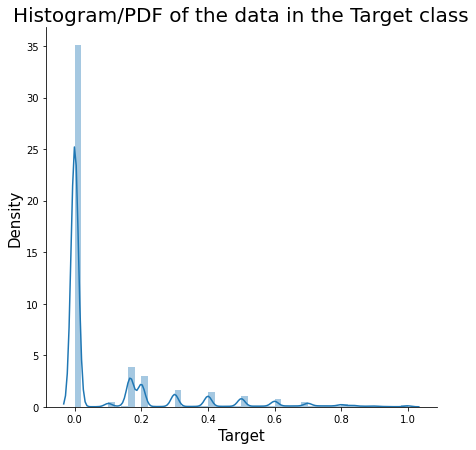

Wall time: 19.4 s


In [17]:
%%time
# Call the function 'plotNumFeature()' to display the PDF of the Target Class.
plotNumFeature(type='Density', data=data, feature='target', figureHeight=6, title='Histogram/PDF of the data in the Target class',
               xlabel='Target', ylabel='Density')

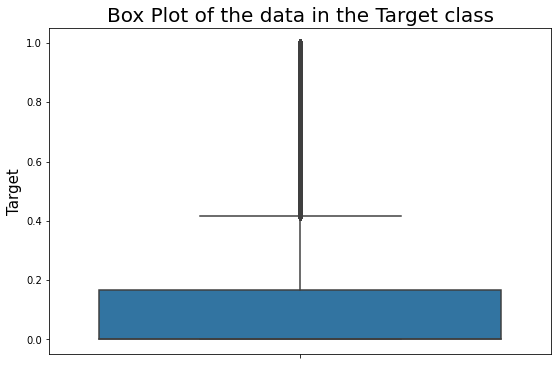

Wall time: 371 ms


In [18]:
%%time
# Call the function 'plotNumFeature()' to display the Box Plot of the Target Class.
plotNumFeature(type='Box', figsize=(9, 6), data=data, feature='target', title='Box Plot of the data in the Target class',
               xlabel='', ylabel='Target')

#### Observation from the PDF and Box Plot of the Target Class

* Most of the comments have 0 toxicity.
* 75% of the data have toxicity less than 0.2 $\implies$ non-toxic comments.
* Majority of the comments have toxicity less than 0.5 $\implies$ non-toxic comments.
* Very few comments are having toxicity greater than 0.5 $\implies$ toxic comments.

### 3.3.2. Count Plot and Pie Chart of the 'Target' Class

* Let's plot the Count Plot for the 'target' class to see the number of comments in each category (toxic and non-toxic).
* We will consider the comments to be toxic if the toxicity is greater than or equal to 0.5, otherwise non-toxic.
* Let's create a new feature called 'IsToxic' to indicate the class label having two values:<br>
&emsp; i. 1 $\implies$ toxic comment (toxicity $\geq$ 5).<br>
&emsp; ii. 0 $\implies$ non-toxic comment (toxicity < 5).<br>

In [19]:
%%time
data['IsToxic'] = data['target'].apply(lambda x: 1 if x >= 0.5 else 0)

Wall time: 561 ms


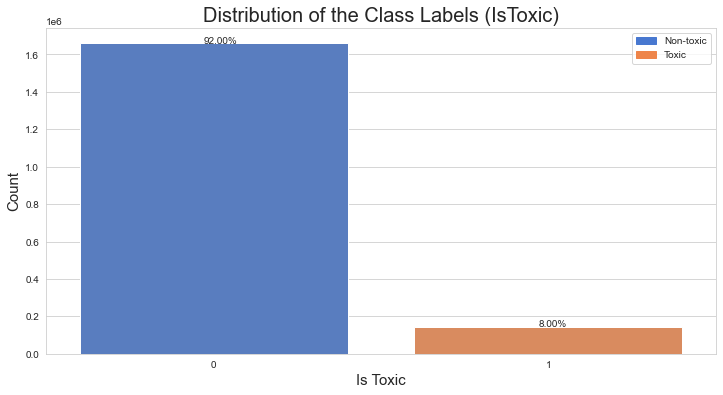

Wall time: 315 ms


In [20]:
%%time
# Call the 'countPlot()' function to plot the Count Plot of the Target Class (IsToxic)
countPlot(figsize=(12, 6), title='Distribution of the Class Labels (IsToxic)', xlabel='Is Toxic', ylabel='Count',
          data=data, feature='IsToxic', legends=['Non-toxic', 'Toxic'], showLegend=True)

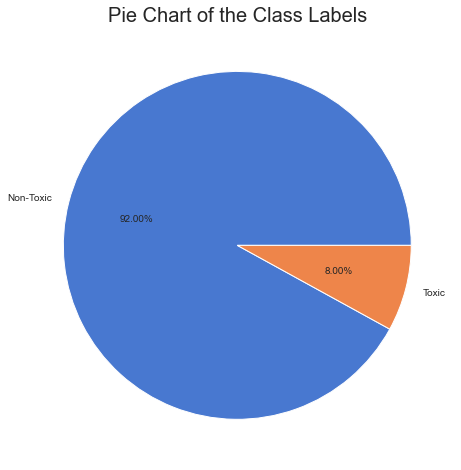

Wall time: 98 ms


In [21]:
%%time
plotPieChart(figsize=(15, 8), title='Pie Chart of the Class Labels', data=data, feature='IsToxic', legends=['Non-Toxic', 'Toxic'])

#### Observation from the Count Plot of the Class Label

* The dataset is **highly imbalanced** with 92% non-toxic comments and 8% toxic comments.



----

## 3.4. Multi-variate Analysis of the Toxicity Subtype Features

* Here, we will do some multi-variate analysis of the various Subgroups or Toxicity Subgroup attributes.
* These attributes represent the subtype of toxicity.
* There are 6 toxicity subgroup attributes available viz., severe_toxicity, obscene, threat, insult, identity_attack, and sexual_explicit.
* In the given problem, the model does not need to predict these attributes. Otherwise, the problem would have been a multi-label classification problem.

In [22]:
# Define the list of Toxicity Subgroups.
subgroups = ['severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']

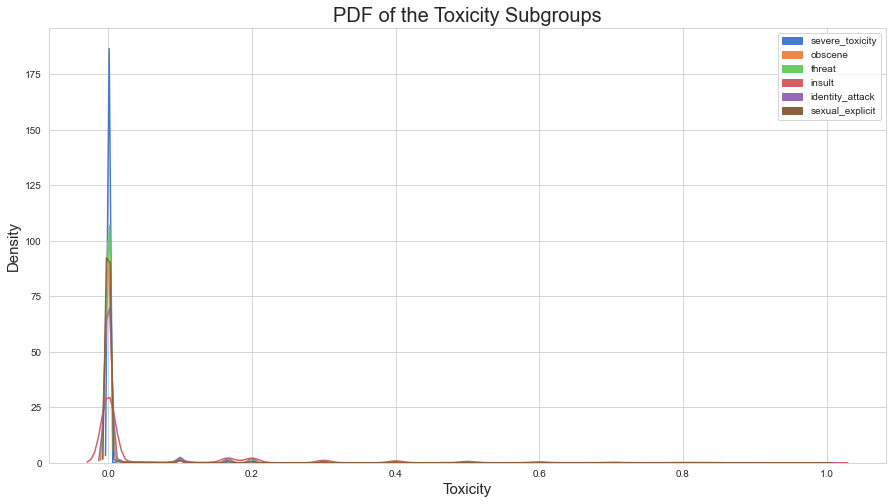

Wall time: 4min 40s


In [29]:
%%time
# Call the 'distPlot()' function to plot the PDF of all the toxicity subgroups in one plot.
distPlot(figsize=(15, 8), title='PDF of the Toxicity Subgroups', xlabel='Toxicity', ylabel='Density', data=data, 
         features=subgroups)

#### Observation

* From the PDF, we can see that most of the toxicity subgroup 'severe_toxicity' are 0 $\implies$ In the training data, comments are least categorized as 'severe_toxicity' by the annotators.

* Let's plot the percentage of subgroup having maximum toxicity in the toxic comments.

In [23]:
def getMaxToxicSubgroup(record, subgroups):
    '''
    Function to return the toxicity subgroup having maximum toxicity in a given record
    
    record: pandas.core.series.Series
        Series containing the toxicity subgroups along with their scores.
    subgroups: list
        List of Toxicity Subgroups.
    '''
    
    # Find the index of the toxicity subgroup having maximum toxicity.
    maxIndex = np.argmax(list(record))
    
    # Return the toxicity subgroup having maximum toxicity
    return subgroups[maxIndex]

In [24]:
%%time
toxicRecords = data[data['target'] >= 0.5]
maxToxicSubgroups = toxicRecords[subgroups].apply(lambda x: getMaxToxicSubgroup(x, subgroups), axis=1)

Wall time: 2.37 s


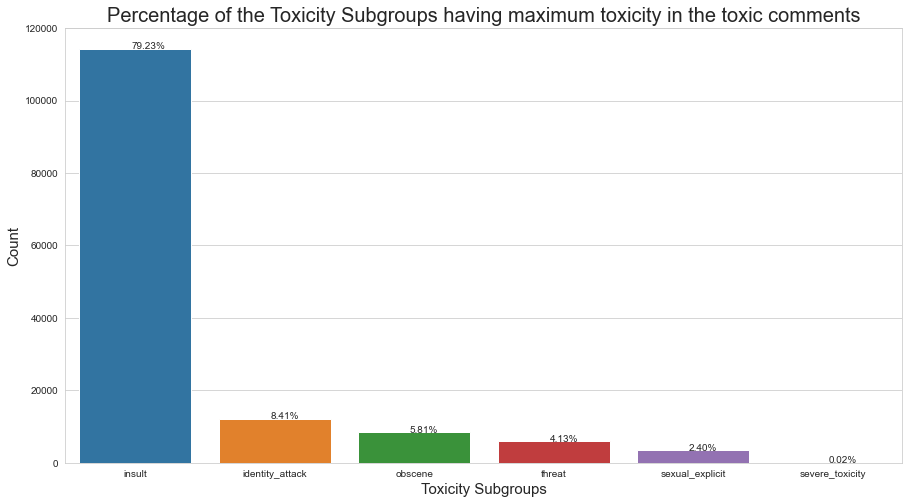

Wall time: 227 ms


In [25]:
%%time
plt.figure(figsize=(15, 8))
ax = sns.countplot(maxToxicSubgroups, order=maxToxicSubgroups.value_counts().index)

plt.title('Percentage of the Toxicity Subgroups having maximum toxicity in the toxic comments', fontsize=20) # Title of the Plot
plt.xlabel('Toxicity Subgroups', fontsize=15) # Label on the x-axis
plt.ylabel('Count', fontsize=15) # Label on the y-axis
plt.xticks(rotation=0)

# Reference: 'seaborn countplot show percentage': https://datascience.stackexchange.com/a/48044
total = len(maxToxicSubgroups) # Total Count
for p in ax.patches:
    percentage = '{:.2f}%'.format(100 * p.get_height()/total) # Percentage of non-null values in the feature
    x = p.get_x() + p.get_width()/2 - 0.03
    y = p.get_y() + p.get_height()

    ax.annotate(percentage, (x, y), rotation=0)

# Show the plot
plt.show()

#### Observation

* We can see that 79.23% of the toxic comments are of 'insult' type, followed by little percentages of 'identity_attack', 'obscene' and others.
* Negligible portion (0.02%) of toxic comments are of 'severe_toxicity' type.
* Based on the above count plot, we could have considered of creating a new feature called 'IsInsult' in doing the classification, due to its huge contribution in the toxic comment. However, we won't get any information related to the toxicity subgroup from the test data. Hence, we would skip this feature.

----

## 3.5. Multi-variate Analysis of the Identity Features

* Here, we will do some multi-variate analysis of the various Identity attributes that represents various identities mentioned in the comments.
* There are 24 identity features in the training dataset viz., **male**, **female**, transgender, other_gender, heterosexual, **homosexual_gay_or_lesbian**, bisexual, other_sexual_orientation, **christian**, **jewish**, **muslim**, hindu, buddhist, atheist, other_religion, **black**, **white**, asian, latino, other_race_or_ethinicity, physical_disability, intellectual_or_learning_disability, **psychiatric_or_mental_illness**, and other_disability.
* Out of these 24 identity attributes, only 9 identities (shown in bold) with more than 500 examples in the test dataset will be included in the evaluation calculation.
* Hence, we will consider only these 9 from the identity features for doing the EDA.

In [26]:
# Define the list of required identities
identities = ['male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish', 'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

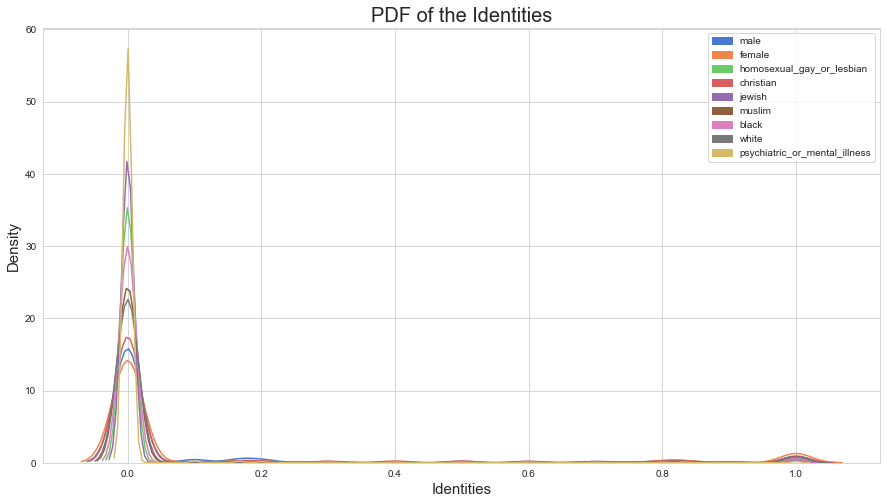

Wall time: 1min 11s


In [91]:
%%time
# Call the 'distPlot()' function to plot the PDF of all the identities in one plot.
distPlot(figsize=(15, 8), title='PDF of the Identities', xlabel='Identities', ylabel='Density', data=data, 
         features=identities)

#### Observation

* From the PDF we can observe that the identity 'psychiatric_or_mental_illness' has highest peak at 0 $\implies$ 'psychiatric_or_mental_illness' is the least mentioned identity in the comments.

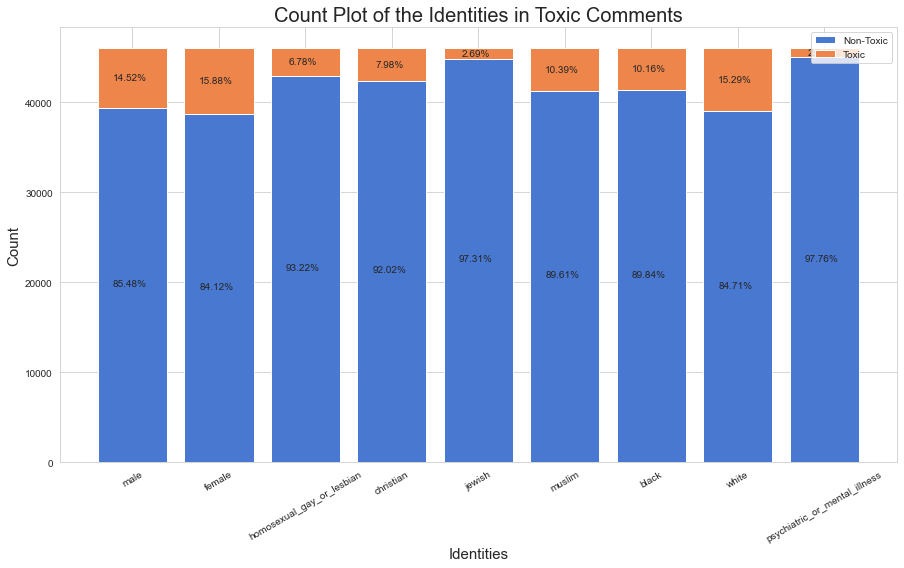

Wall time: 737 ms


In [27]:
%%time
# Call the 'barPlot()' function to plot the Count Plot of the Identities for toxic comments.
barPlot(figsize=(15,8), title='Count Plot of the Identities in Toxic Comments', xlabel='Identities', ylabel='Count', 
        data=data, features=identities, xtickRotate=30)

#### Observation

* 'female' is most occuring identity in the toxic comments, followed by the identities: 'male', 'white', 'muslim', and so on.

----

## 3.6. Uni-variate Analysis of the Comment Text

* Here, we will perform various EDA on the comment text which is the most important feature in whole dataset.

### 3.6.1. Plot number of comments per toxic class

* Let's draw a count plot to view the number of toxic comments as well as the number of comments in each toxic subgroup where the score is greater than or equal to 50% ($\geq$ 0.5).

In [28]:
toxicFeatures = ['target'] + subgroups
print('Toxic features to consider: ', toxicFeatures)

Toxic features to consider:  ['target', 'severe_toxicity', 'obscene', 'threat', 'insult', 'identity_attack', 'sexual_explicit']


In [29]:
%%time

# Create a dictionary with keys for each toxic class and its value for the number of toxic comments
dictToxicClass = {key: 0 for key in toxicFeatures}

# Iterate through each of the features and increment the count of the toxic class in case the comment has toxicity >= 0.5
for feature in tqdm(toxicFeatures):
    
    # Count the number of toxic comments belong to the main toxic class and to each toxicity subgroup
    dictToxicClass[feature] = data[feature].apply(lambda x: 1 if x >= 0.5 else 0).sum()
    
    # Reference: 'How to sort dictionary by value' - https://stackoverflow.com/a/613218/16007029
    # Sort the dictionary in descreasing order of its values
    dictToxicClass = {key:value for key, value in sorted(dictToxicClass.items(), key=lambda item: item[1], reverse=True)}

  0%|          | 0/7 [00:00<?, ?it/s]

Wall time: 4.05 s


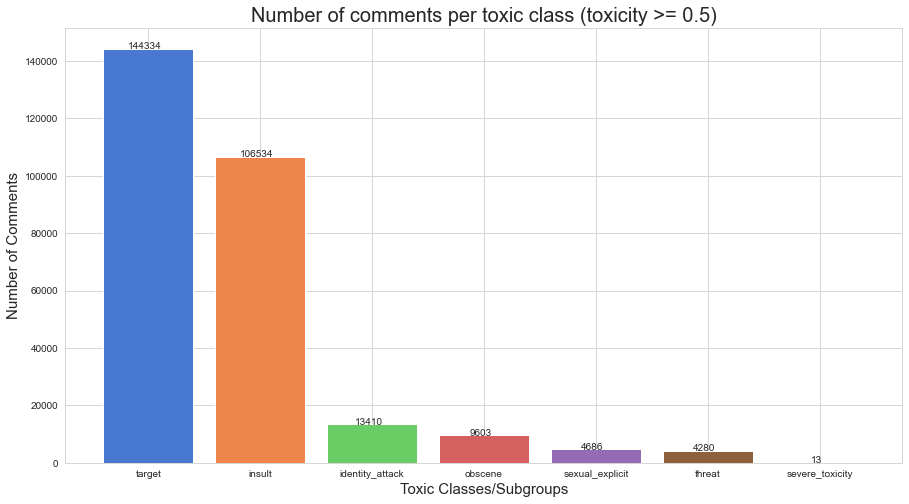

Wall time: 186 ms


In [30]:
%%time
# Get the legend's color palette
dictLegends = getPlotLegends(list(dictToxicClass.keys()))

plt.figure(figsize=(15, 8)) # Plot figure size
ax = plt.bar(dictToxicClass.keys(), height=dictToxicClass.values(), color=dictLegends.keys()) # Bar Plot
plt.title('Number of comments per toxic class (toxicity >= 0.5)', fontsize=20) # Title of the Plot
plt.xlabel('Toxic Classes/Subgroups', fontsize=15) # Label for x-axis
plt.ylabel('Number of Comments', fontsize=15) # Label for y-axis

# Annotate the Count
for p in ax.patches:
    x = p.get_x() + p.get_width()/2 - 0.03
    y = p.get_y() + p.get_height()
    plt.annotate(p.get_height(), (x, y), rotation=0, ha='center')
            
plt.show()

#### Observation

* There are a total of 144334 toxic comments.
* From the toxic subgroups, 'insult' has been attributed in maximum comments by minimum 50% annotators.
* Rest all toxic subgroups are less annotated.
* 'severe_toxicity' subgroup is the least attributed subgroup annotated by any annotators.

----

### 3.6.2. Plot the distribution of comments over time

* Here, we will plot the distribution of comments over time.

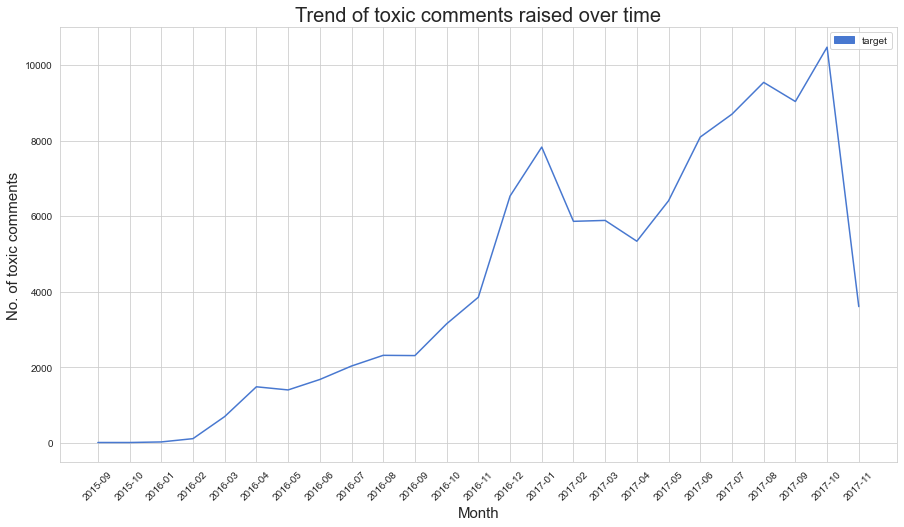

Wall time: 2.96 s


In [31]:
%%time
# Call the function 'plotTrendGraph()' to show the number of toxic comments created over time.
plotTrendGraph(figsize=(15, 8), title='Trend of toxic comments raised over time', xlabel='Month', 
               ylabel='No. of toxic comments', data=data, features=['target'], threshold=0.5, xtickRotate=45)

#### Observation from the trend of toxic comments raised over time

* We can see an overall upward trend in the number of toxic comments raised over time.
* There is a slight dip after Jan 2017 but the trend increases again after April 2017.
* The maximum number of toxic comments were raised in October 2017.
* There is a drastic fall after October 2017 in the next month. This could be due to unavailability of the data in Nov 2017 and onwards.

* Let's try to plot the similar trend graph for various types of toxicity subgroups.
* However, if we just consider the score to be greater than 0.5 for each of the subgroups, there is negligible data and the graph does not show any trend.
* Hence, we will plot the trend graph for the toxicity subgroups considering a non-zero score i.e., even if atleast one annotator believed the comment to be of any specific toxicity, we would consider them in the trend graph.

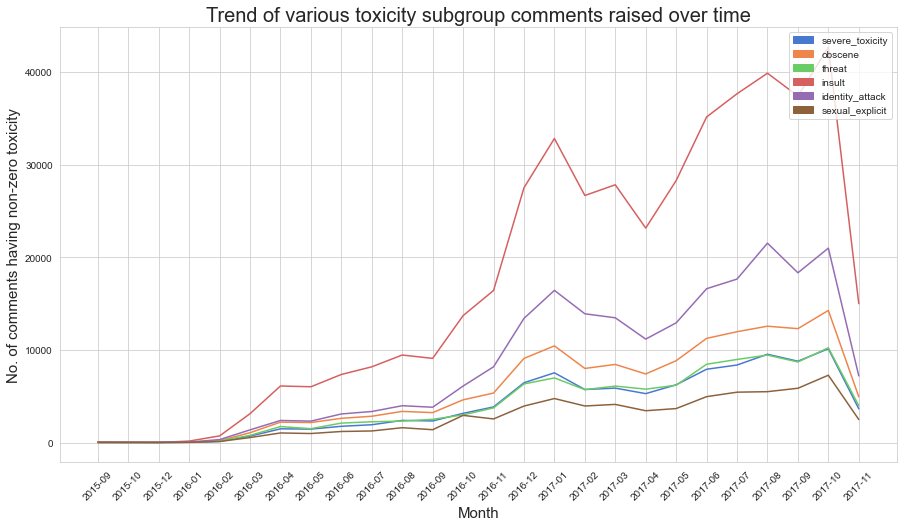

Wall time: 4.02 s


In [32]:
%%time
# Call the function 'plotTrendGraph()' to show the number of various toxicity subgroup comments created over time.
# Here, we are plotting by taking the toxicity threshold as anything greater than 0 because there are very less data
# with toxicity greater than 0.5 for the toxicity subgroups.
plotTrendGraph(figsize=(15, 8), title='Trend of various toxicity subgroup comments raised over time', xlabel='Month',
               ylabel='No. of comments having non-zero toxicity', data=data, features=subgroups, threshold=0,
               xtickRotate=45)

#### Observation from the trend of various toxicity subgroup comments raised over time

* The trend for all the toxicity subgroup comments follow similar pattern.
* The comments marked as 'insult' show a significant increase than any other kind of comments. 

----

### 3.6.3. Plot the distribution of comments length

* Here, we will plot the distribution of length of the comments for both toxic and non-toxic class.

In [95]:
%%time
# Create a new feature 'comment_length' to signify the length of comment i.e., number of words in the comments.
data['comment_length'] = data['comment_text'].apply(lambda x: len(x.split()))

Wall time: 16.4 s


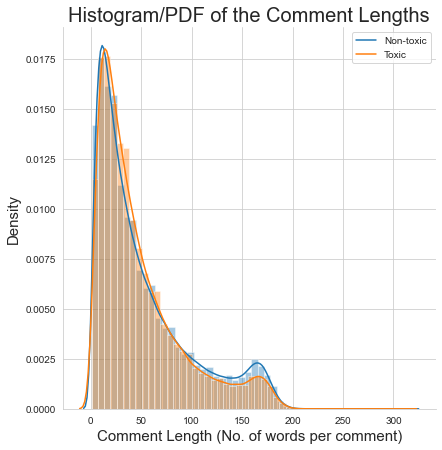

Wall time: 48.3 s


In [96]:
%%time
# Call the function 'plotNumFeature()' to display the PDF of the comment length for both toxic and non-toxic class.
plotNumFeature(type='Density', data=data, feature='comment_length', figureHeight=6, hue='IsToxic',
               title='Histogram/PDF of the Comment Lengths', 
               xlabel='Comment Length (No. of words per comment)', ylabel='Density')

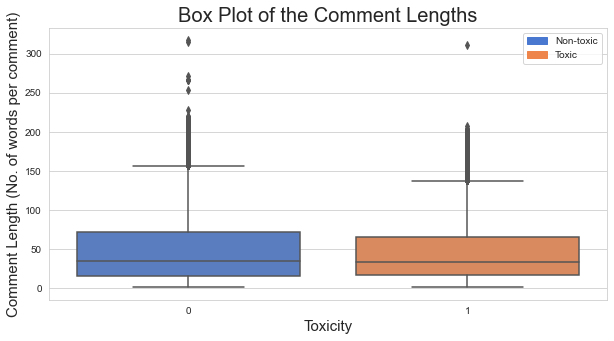

Wall time: 1.11 s


In [110]:
%%time
# Call the function 'plotNumFeature()' to display the Box Plot of the comment length for both toxic and non-toxic class.
plotNumFeature(type='Box', data=data, feature='comment_length', figureHeight=6, hue='IsToxic',
               title='Box Plot of the Comment Lengths', figsize=(10, 5),
               ylabel='Comment Length (No. of words per comment)', xlabel='Toxicity')

#### Observation from the distribution of comment lengths

* The comment lengths follow the similar distribution for both toxic and non-toxic classes.
* Most of the comments (either toxic or non-toxic) have length between 10-30.
* Almost all comments have length less than 150 words. However, there are some outliers with comment lengths even upto 350+ words.

----

### 3.6.4. Word Cloud of the words in Comment Text

### 3.6.5. Word Cloud of the words in Comment Text - Toxic and Non-toxic Class

* Plot the word cloud of all the words in the comment text from toxic and non-toxic classes separately and see which all words are mostly used in the comments.

  0%|          | 0/1 [00:00<?, ?it/s]

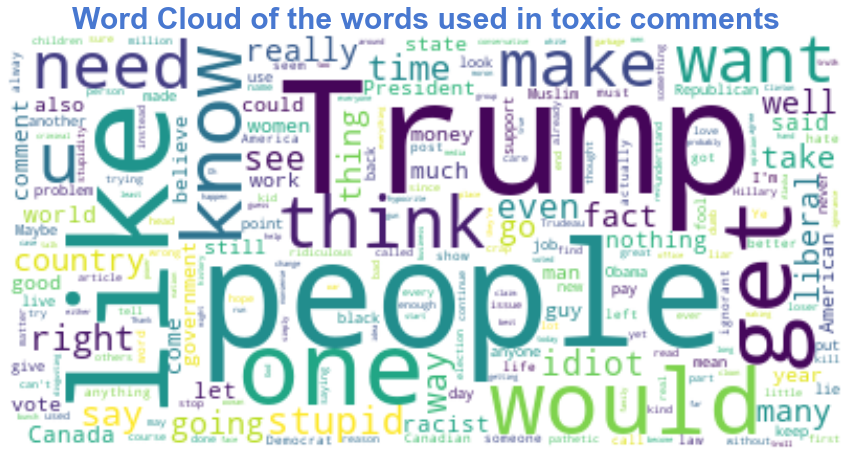

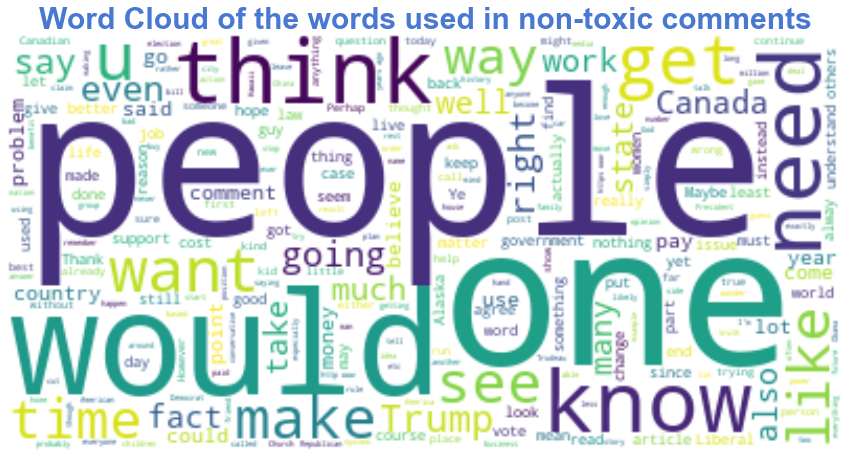

Wall time: 8min 20s


In [191]:
%%time
# Call the function 'generateWordCloud()' to generate word cloud for the toxic and non-toxic classes.
generateWordCloud(figsize=(15, 8), data=data, features=['target'])

#### Observation from the Word Cloud of the words in comment texts from toxic and non-toxic classes

* In the toxic comments, 'Trump', 'people' and 'like' are the most often used words in the comment texts.
* In the non-toxic comments, 'people' 'one' and 'would' are the most often used words.

----

### 3.6.5. Word Cloud of the words in Comment Text - Toxicity Subgroup Classes

* Plot the word cloud of all the words in the comment text from various toxicity subgroup classes having score greater than or equal to 0.5

  0%|          | 0/6 [00:00<?, ?it/s]

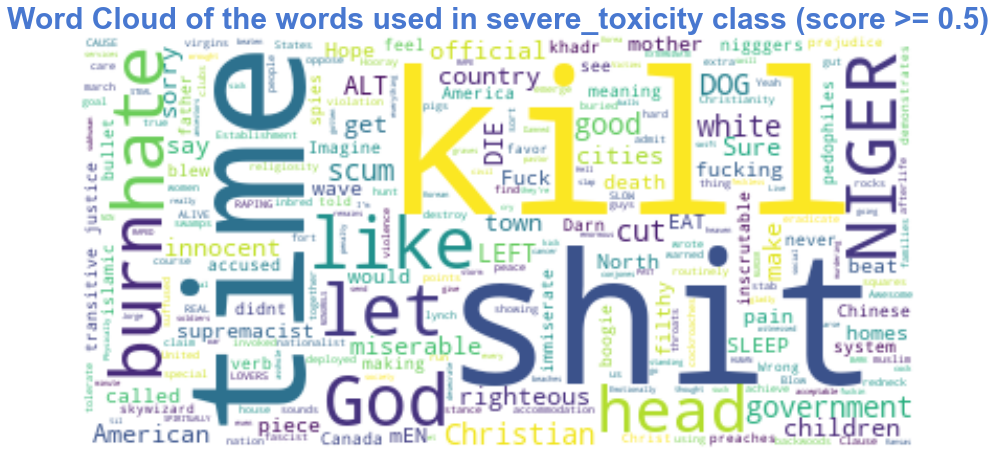

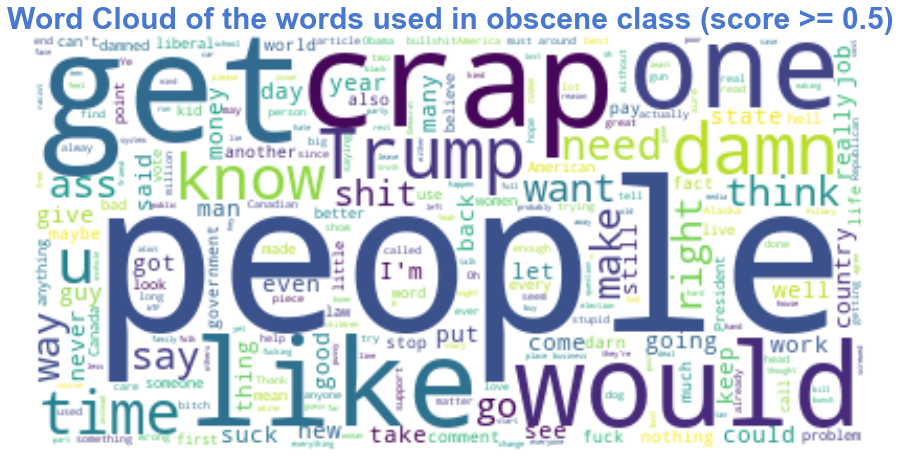

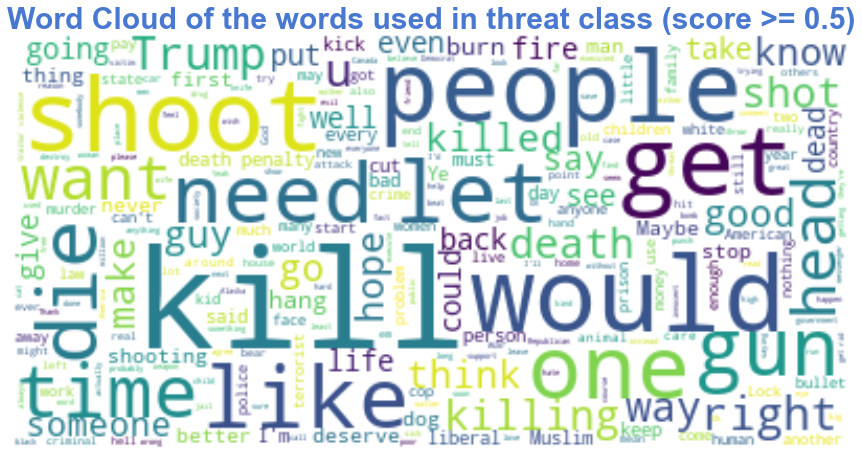

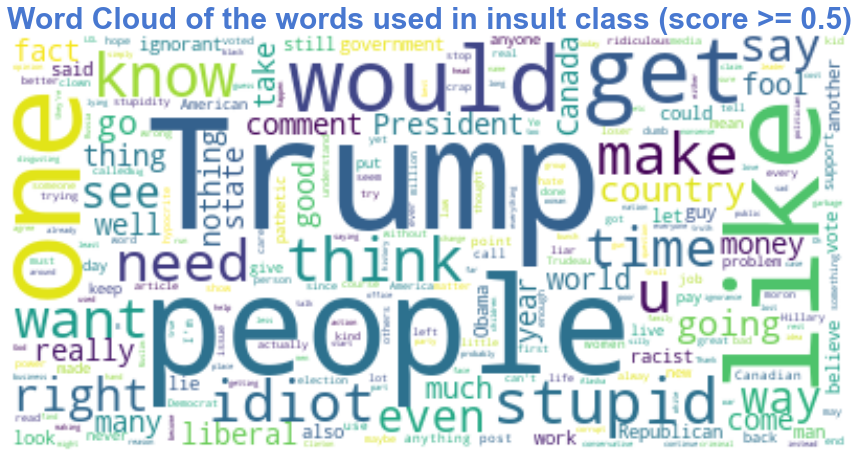

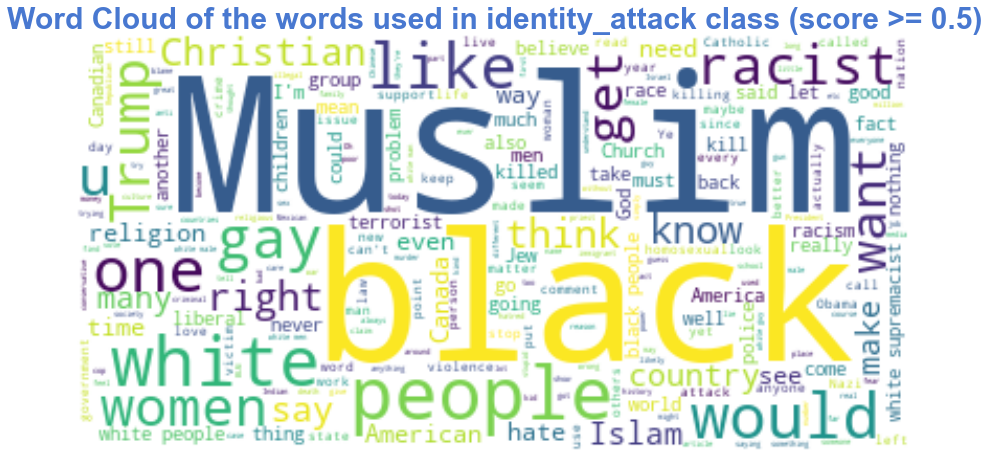

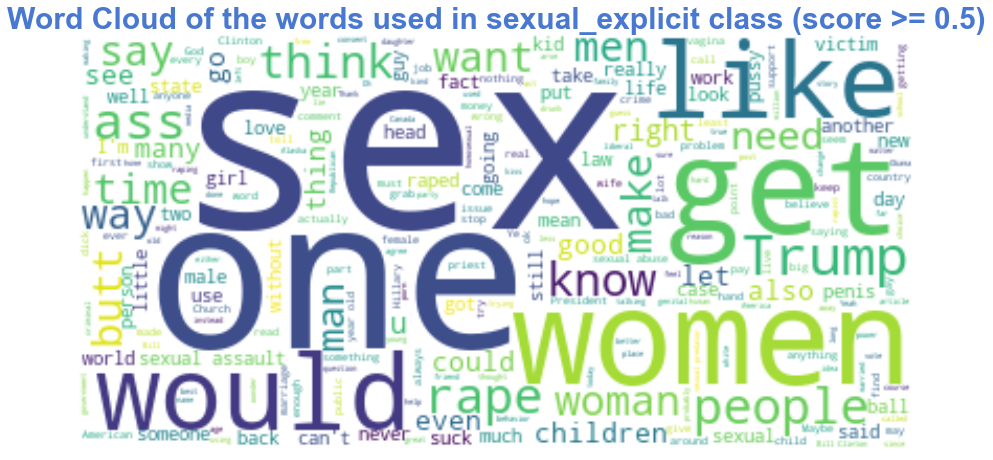

Wall time: 27.3 s


In [192]:
%%time
# Call the function 'generateWordCloud()' to generate word cloud for all the toxicity subgroup classes.
generateWordCloud(figsize=(15, 8), data=data, features=subgroups)

#### Observation from the Word Cloud of the words in comment texts of varioud toxicity subgroup classes

* Most often used words based on the toxicity subgroup classes are as follows:<br>
&emsp; i. severe_toxic: kill, shit and time.<br>
&emsp; ii. obscene: people, get, like, would and crap.<br>
&emsp; iii. threat: kill and shoot.<br>
&emsp; iv. insult: Trumpt, people, like and one.<br>
&emsp; v. identity_attack: Muslim and black.<br>
&emsp; vi. sexual_explicit: sex and one.<br>

----